
![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - OBD matrix
In this tutorial you generate an overlapping B-mode deprojection matrix, and apply it to a noisemodel using a masked sky.
At the end of this tutorial, you will plot the power spectrum of a single simulation, and deproject its B-modes using the OBD matrix.

This tutorial uses two configuration files. The [first](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_buildOBD.py) is for generating the OBD matrix, and you can freely change the parameters to your liking. 

The 
 * `DLENSALOT_Analysis` is mainly needed for pointing D.lensalot to the mask you will generate in this notebook,
 * `DLENSALOT_Noisemodel` configures the noise model. You should choose the setting applicable to the simulations and/or data you'd like to deproject,
 * `DLENSALOT_OBD` defines where the Matrix temp and final files are stored and other simulation and/or data specific settings


In [1]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp


import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

from lenscarf.lerepi.visalot import plot_helper as ph

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


In [50]:
logo_flat = logo[:,:,0].flatten()
print(logo_flat.shape)
hp.nside2npix(256)

(890358,)


786432

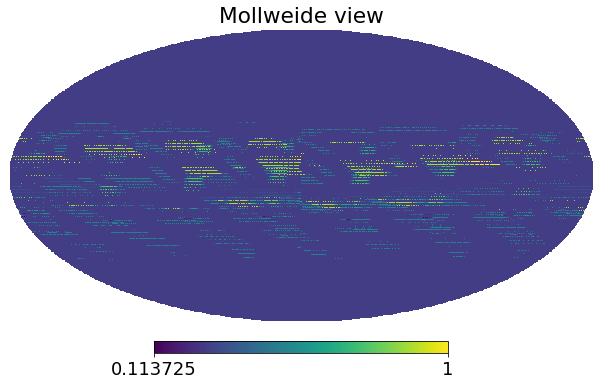

In [51]:
hp.mollview(logo_flat[:786432])

fsky: 0.583


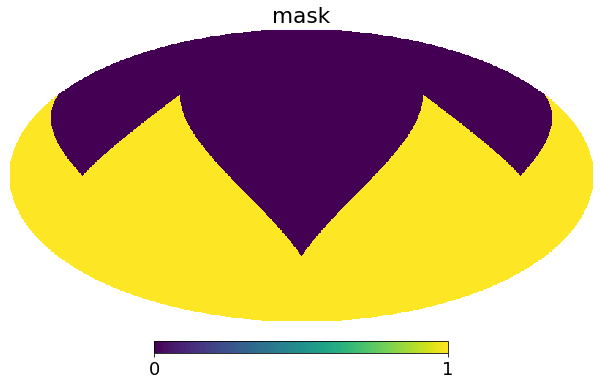

In [2]:
m = np.zeros(hp.nside2npix(1))
m[[5,6,7,8,9,10,11]] = 1
m = hp.ud_grade(m, nside_out=512)
hp.mollview(m, nest=False, title='mask')
print('fsky: {:.3f}'.format(np.mean(m)))

# Create mask
Due to masking the noise model is no longer isotropic.

fsky: 0.083
mask stored at /pscratch/sd/s/sebibel/OBDmatrix_nside128_lmax300/mask.fits


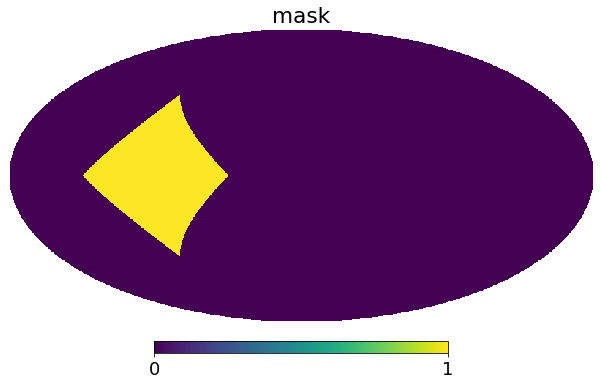

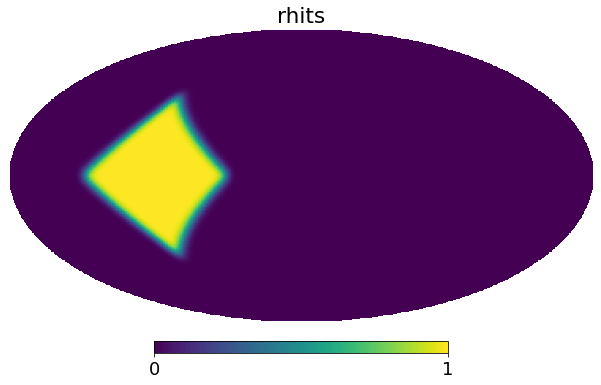

In [2]:
m = np.zeros(hp.nside2npix(1))
m[5] = 1
# m[8] = 1
rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=128),0.1))
mask = hp.ud_grade(m, nside_out=128)
hp.mollview(mask, nest=False, title='mask')
hp.mollview(rhits, nest=False, title='rhits')
print('fsky: {:.3f}'.format(np.mean(m)))

# fn = '/global/homes/s/sebibel/git/notebooks/dlensalot/dev/conf_mwe_buildOBD.py'
# ana_mwe = run(config=fn, job_id='build_OBD', verbose=False).job
mask_fn = opj(os.environ['SCRATCH'], 'OBDmatrix_nside128_lmax300/mask.fits') #opj(ana_mwe.TEMP,'mask.fits')
rhits_fn = opj(os.environ['SCRATCH'], 'OBDmatrix_nside128_lmax300/rhits.fits') #opj(ana_mwe.TEMP,'mask.fits')

if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    hp.write_map(rhits_fn, rhits)
    print('mask stored at {}'.format(mask_fn))

# Create the OBD matrix
This may take a while (~120minutes), go grab a coffee

In [ ]:
fn = '/global/homes/s/sebibel/git/notebooks/dlensalot/dev/conf_mwe_buildOBD.py'
ana_mwe = run(config=fn, job_id='build_OBD', verbose=True).job
ana_mwe.run()

INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/homes/s/sebibel/git/notebooks/dlensalot/dev/conf_mwe_buildOBD.py
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-06 01:33:: root.store - config file stored at /pscratch/sd/s/sebibel/OBDmatrix_nside128_lmax300/conf_mwe_buildOBD.py
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - collect_jobs() Finished
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - get_jobs() Started
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - get_jobs() Finished
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.log - init_job() Started
INFO:: 02-06 01:33:: lenscarf.lerepi.core.handler.init_job - transform started
INFO:: 02-06 01:33:: lens

# Apply to simulation data
The second [configuration file](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_applyOBD.py)
generates a single simulated CMB inclusive of some noise, applies the above generated mask, and applies the OBD matrix on the noise-model to correctly deproject the B-modes

In [ ]:
fn = '/global/homes/s/sebibel/git/notebooks/dlensalot/dev/conf_mwe_applyOBD.py'
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job

# Check result
You can test if it worked by plotting the B spectra after Wiener-filtering

In [ ]:
b = ana_mwe._sims.get_sim_blm(0)
ivf_b = ana_mwe.ivfs.get_sim_bmliklm(simidx)
plt.plot(hp.alm2cl(ivf_e), label='$C_\ell^{BB}$')
plt.plot(hp.alm2cl(ivf_b), label='$\bar{C}_\ell^{BB}$')
plt.yscale('log')
plt.xlim(0,300)

plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')
plt.legend()
plt.show()

In [2]:
tnit = np.load(os.environ['HOME']+'/tnit.npy')

In [ ]:
tniti = np.linalg.inv(tnit[:40397,:40397])

In [ ]:
plt.imshow